<ipython-input-2-856f8c33f2c9>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


데이터 형태: (1798, 9)
컬럼: Index(['USDKRW', 'SP500', 'US10YR', 'MA7', 'MA30', 'RSI', 'Volatility',
       'Month', 'DayOfWeek'],
      dtype='object')
첫 몇 행:
                                 USDKRW        SP500  US10YR          MA7  \
Date                                                                       
2019-10-11 00:00:00+00:00  1188.810059  2970.270020   1.752  1194.277152   
2019-10-12 00:00:00+00:00  1188.810059  2970.270020   1.752  1192.667167   
2019-10-13 00:00:00+00:00  1182.489990  2970.270020   1.752  1191.404314   
2019-10-14 00:00:00+00:00  1182.300049  2966.149902   1.733  1189.481463   
2019-10-15 00:00:00+00:00  1183.930054  2995.679932   1.771  1187.418614   

                                  MA30        RSI  Volatility  Month  \
Date                                                                   
2019-10-11 00:00:00+00:00  1193.338997  38.197173    7.104242     10   
2019-10-12 00:00:00+00:00  1193.607666  38.197173    6.755586     10   
2019-10-13 00:00:00+00:00

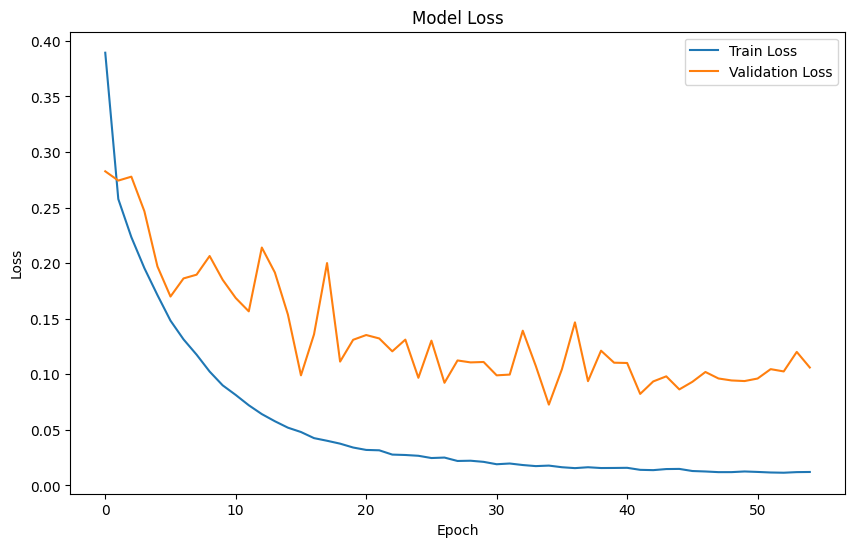

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

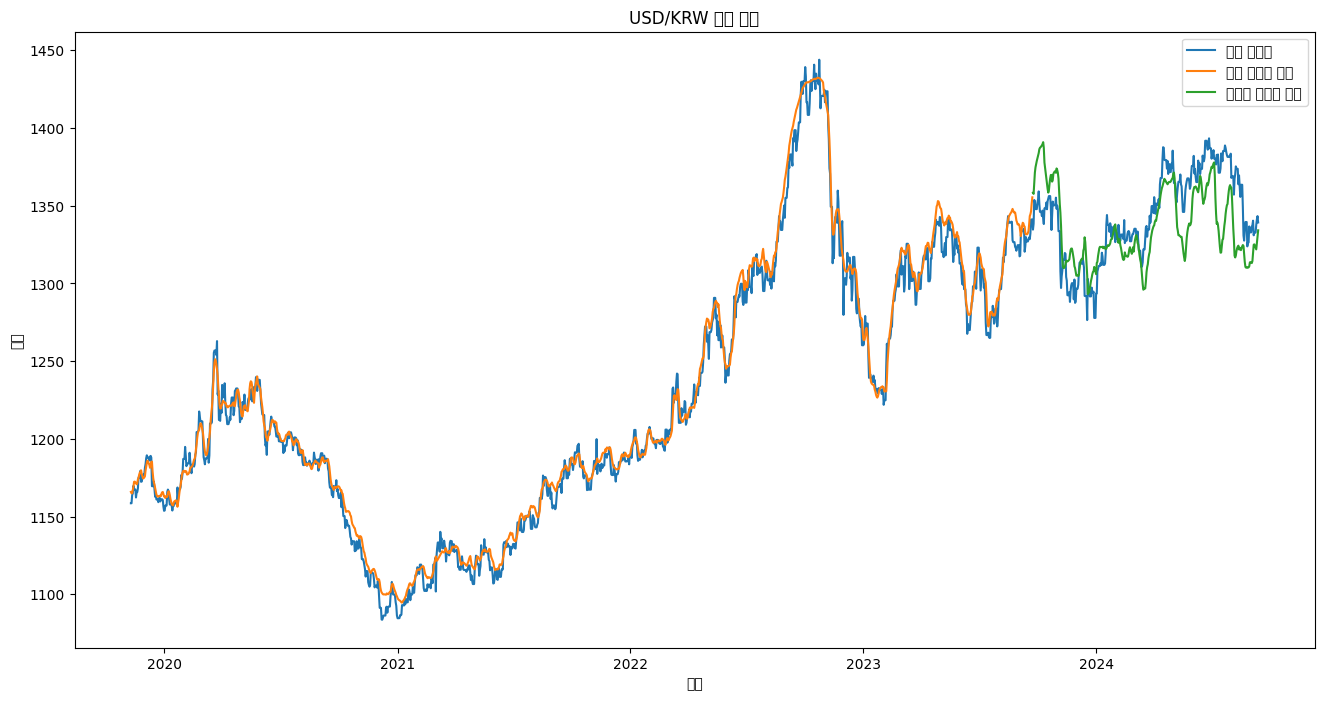


모델 평가:
훈련 데이터 RMSE: 8.0670
훈련 데이터 MAE: 6.1813
훈련 데이터 R2 Score: 0.9905
테스트 데이터 RMSE: 23.3050
테스트 데이터 MAE: 18.9559
테스트 데이터 R2 Score: 0.3263


ValueError: cannot reshape array of size 540 into shape (1,30,9)

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 수집 함수
def get_data():
    # USD/KRW 환율 데이터
    usd_krw = yf.Ticker("KRW=X")
    fx_data = usd_krw.history(period="5y")

    # S&P 500 지수 데이터 (시장 지표로 사용)
    sp500 = yf.Ticker("^GSPC")
    sp500_data = sp500.history(period="5y")

    # 미국 10년 국채 수익률 데이터
    treasury = yf.Ticker("^TNX")
    treasury_data = treasury.history(period="5y")

    # 데이터 병합
    data = pd.concat([fx_data['Close'], sp500_data['Close'], treasury_data['Close']], axis=1)
    data.columns = ['USDKRW', 'SP500', 'US10YR']

    # 일별 데이터로 리샘플링 (마지막 값 사용)
    data = data.resample('D').last()

    # 전진 채우기로 NaN 값 처리
    data = data.fillna(method='ffill')

    # 남아있는 NaN 값 제거 (주로 시계열의 시작 부분)
    data = data.dropna()

    return data

# 특성 엔지니어링 함수
def engineer_features(data):
    # 이동평균
    data['MA7'] = data['USDKRW'].rolling(window=7).mean()
    data['MA30'] = data['USDKRW'].rolling(window=30).mean()

    # 상대강도지수(RSI)
    delta = data['USDKRW'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # 변동성
    data['Volatility'] = data['USDKRW'].rolling(window=30).std()

    # 계절성 (월, 요일)
    data['Month'] = data.index.month
    data['DayOfWeek'] = data.index.dayofweek

    # NaN 값 제거
    return data.dropna()

# 데이터 준비
data = get_data()
data = engineer_features(data)

# 데이터가 비어있지 않은지 확인
if data.empty:
    raise ValueError("데이터프레임이 비어 있습니다. 데이터를 확인해 주세요.")

print("데이터 형태:", data.shape)
print("컬럼:", data.columns)
print("첫 몇 행:\n", data.head())

# 데이터 정규화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 30
X, y = create_dataset(scaled_data, time_step)

# 데이터 분할
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM 모델 구축
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

# 옵티마이저 및 학습률 스케줄러 설정
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001)

# 모델 훈련
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=200, batch_size=32, callbacks=[early_stop, lr_scheduler], verbose=1)

# Loss 시각화 함수
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Loss 시각화
plot_loss(history)

# 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 예측값 역정규화
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]

# 실제 데이터
actual_data = scaler.inverse_transform(scaled_data)[:, 0]

# 결과 시각화
plt.figure(figsize=(16,8))
plt.plot(data.index[time_step:], actual_data[time_step:], label='실제 데이터')
plt.plot(data.index[time_step:len(train_predict)+time_step], train_predict, label='훈련 데이터 예측')
plt.plot(data.index[len(train_predict)+time_step:], test_predict, label='테스트 데이터 예측')
plt.legend()
plt.title('USD/KRW 환율 예측')
plt.xlabel('날짜')
plt.ylabel('환율')
plt.show()

# 모델 평가
# 훈련 데이터에 대한 평가
train_mse = mean_squared_error(actual_data[time_step:len(train_predict)+time_step], train_predict)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(actual_data[time_step:len(train_predict)+time_step], train_predict)
train_r2 = r2_score(actual_data[time_step:len(train_predict)+time_step], train_predict)

# 테스트 데이터에 대한 평가
test_mse = mean_squared_error(actual_data[len(train_predict)+time_step:], test_predict)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(actual_data[len(train_predict)+time_step:], test_predict)
test_r2 = r2_score(actual_data[len(train_predict)+time_step:], test_predict)

print("\n모델 평가:")
print(f"훈련 데이터 RMSE: {train_rmse:.4f}")
print(f"훈련 데이터 MAE: {train_mae:.4f}")
print(f"훈련 데이터 R2 Score: {train_r2:.4f}")
print(f"테스트 데이터 RMSE: {test_rmse:.4f}")
print(f"테스트 데이터 MAE: {test_mae:.4f}")
print(f"테스트 데이터 R2 Score: {test_r2:.4f}")

# 향후 30일 예측
last_60_days = scaled_data[-60:]
future_predictions = []

for _ in range(30):
    next_day_pred = model.predict(last_60_days.reshape(1, time_step, scaled_data.shape[1]))
    future_predictions.append(next_day_pred[0, 0])
    next_day_features = np.zeros((1, scaled_data.shape[1]))
    next_day_features[0, 0] = next_day_pred[0, 0]
    last_60_days = np.vstack((last_60_days[1:], next_day_features))

future_predictions = scaler.inverse_transform(np.concatenate((np.array(future_predictions).reshape(-1, 1), np.zeros((30, scaled_data.shape[1]-1))), axis=1))[:, 0]

print("\n향후 30일 예측 환율:")
for i, price in enumerate(future_predictions):
    print(f"{i+1}일 후: {price:.2f}")